In [1]:
!pwd

/dli/task/ComParE2022_VecNet/notebooks/DK


In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [3]:
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_1.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_2.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_3.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_4.zip?download=1

In [4]:
# !unzip /content/humbugdb_neurips_2021_1.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_2.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_3.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_4.zip?download=1 -d '/content/HumBugDB/data/audio'

In [5]:
!pip install torch_audiomentations
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [7]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [8]:
# other dependencies
#!pip install timm ipywidgets

In [9]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [10]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [11]:
!pwd

/dli/task/ComParE2022_VecNet/notebooks/DK


In [12]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import config ,config_pytorch
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [13]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [14]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [15]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [16]:
#torch.autograd.set_detect_anomaly(True)

In [17]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers= 8
pin_memory=True
#train_size = 100
batch_size = 64
test_batch_size = 64
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 200

In [18]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [19]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]


### Read CSV and get train/test groups

In [20]:
# if DEBUG:
#     df = pd.read_csv(config.data_df_msc_test)
# else:
df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [21]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [22]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
# other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
# df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [23]:
df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
#other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
#df.loc[other_df_ind,'specie_ind']= other_ind        

At this stage we have all extracted the data with specie information and have encoded the specie encoding in a col = 'specie_ind'

In [24]:
#extracting the TZ and Cup data- this is as per the humbug paper

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [25]:
df_all.reset_index(inplace=True)

In [26]:
df_all

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,4546,222615,30.72,IFA_86_39_3439.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2284,4547,222585,25.60,IFA_86_40_3440.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2285,4548,222586,40.90,IFA_87_10_3450.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2286,4549,222596,40.90,IFA_87_11_3451.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


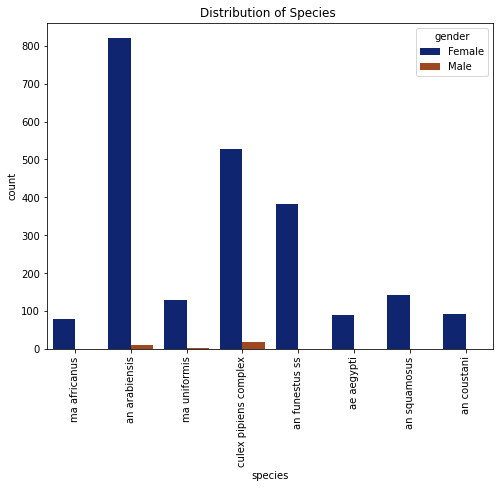

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
import seaborn as sns
sns.countplot(x = 'species', data = df_all , ax = ax , hue = 'gender',palette='dark')
#ax.bar_label(ax.containers[0])
#ax.bar_label(ax.containers[-1], fmt='Count:\n%.2f', label_type='center')
plt.xticks(rotation=90 )
plt.title("Distribution of Species ")
plt.rc('xtick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('axes', labelsize=15)
plt.rc('figure', titlesize=15)

### Train-Test split( avoiding sklearn )

In [28]:
np.random.seed(42)
msk_test = np.random.rand(len(df_all)) < 0.2
df_test = df_all[msk_test]
df_train_temp  = df_all[~msk_test]


In [29]:
np.random.seed(42)
msk_train = np.random.rand(len(df_train_temp)) < 0.2
df_val = df_train_temp[msk_train]
df_train  = df_train_temp[~msk_train]

## Let's verify for data leakage by performing an inner-join on id

In [30]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [31]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [32]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


We've confirmed that there is no recording that is common in Train,Test,val

### Next, we perform "offsets", spliting each(long) recording into multiple 1.92 secs chunk. 

In [33]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [34]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 32239
length of test offset = 10087
length of val offset = 8692


In [35]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



### Let's check for data leakage in offsets

In [36]:
pd.merge(df_train_offset , df_test_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [37]:
pd.merge(df_train_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [38]:
pd.merge(df_test_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


### At this stage we've a dataframe of recordin ids and each row corresponds to a 1.92 secs recording or shorter


In [39]:
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [40]:
#Class imbalance 
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.32298429 0.56615271 3.6109991  0.61779473 1.98809817 4.24197368
 3.08802682 5.57382434]


Let us now get the class distribution for each of the dataframes- train,test and val

In [41]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
12477
DF type = train
i = 1
7118
DF type = train
i = 2
1116
DF type = train
i = 3
6523
DF type = train
i = 4
2027
DF type = train
i = 5
950
DF type = train
i = 6
1305
DF type = train
i = 7
723


In [42]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
3613
DF type = Val
i = 1
1994
DF type = Val
i = 2
230
DF type = Val
i = 3
1855
DF type = Val
i = 4
280
DF type = Val
i = 5
228
DF type = Val
i = 6
426
DF type = Val
i = 7
66


In [43]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
4356
DF type = test
i = 1
1879
DF type = test
i = 2
439
DF type = test
i = 3
1959
DF type = test
i = 4
507
DF type = test
i = 5
312
DF type = test
i = 6
441
DF type = test
i = 7
194


In [44]:
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [45]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [46]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [47]:
def apply_aug(spec_gram , aug_flag = "Y", newsize = (1025, 31)):
        
        from torchvision.transforms.autoaugment import AutoAugmentPolicy
        import torchvision.transforms as transforms
        
        aug_flag_y = transforms.Compose([
            transforms.GaussianBlur(3),#image conversion
            transforms.RandomErasing(),
            transforms.Normalize(mean = 2.7360104e-05 , std = .0061507192)
            ])
        
        
        aug_flag_n = transforms.Compose([
            transforms.Normalize(mean = 2.7360104e-05 , std = .0061507192)
            ])
        
            
        
        if (aug_flag == "Y"):
            rgb_img_auto_aug = aug_flag_y(spec_gram)
            #print("type(rgb_img_auto_aug) = " +str(type(rgb_img_auto_aug)))
            
            return rgb_img_auto_aug
        else:
            
            img_tensor = aug_flag_n(spec_gram)
            #print("type(img_tensor) = " +str(type(img_tensor)))
            return img_tensor


In [48]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [49]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [50]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,221103,0,2.56,7
1,1,221111,0,2.56,7
2,2,221110,0,2.56,7
3,3,221149,0,2.56,0
4,4,221144,0,2.56,1


In [51]:
def get_error_df(loader , trained_model, DEBUG = False):
    err_dict = {'id': None,
               'label': None,
               'offset':None,
               'y_hat':None}
    model = trained_model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        all_wav_id = []
        all_offset = []
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y,offset,wav_id) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                print("y = " + str(y))
                print("offset = " + str(offset))
                print("wav_id = " + str(wav_id))
                
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
            all_y.append(y.cpu().detach())
            all_wav_id.append(wav_id.cpu().detach())
            all_offset.append(offset.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred)
        all_wav_id = torch.cat(all_wav_id)
        all_offset = torch.cat(all_offset)
        
        err_dict['id'] = all_wav_id
        err_dict['label'] = all_y
        err_dict['offset'] = all_offset
        err_dict['y_hat'] = all_y_pred
        df_err = pd.DataFrame.from_dict(err_dict)
        df_err_uniq = df_err[df_err['label']!= df_err['y_hat']]
        df_err_uniq.sort_values(by=['id','offset'])

        
        
        
        if DEBUG:
            print("inside error ....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        #test_loss = test_loss/len(test_loader)
        #test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return df_err_uniq

In [52]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred_smax, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [53]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.create_optimizer_v2(model.parameters(), lr=config_pytorch.lr/10,opt = 'lookahead_adam')
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            if DEBUG:
                print("inside train loop.. x device = " +str(x.device))
                
            y = inputs[1].type(torch.LongTensor).to(device)
            #global_step += 1
            # AMP
            x_sum = torch.sum(x,axis = 1)
            x_sum.unsqueeze(dim = 1)
            zero_chk = torch.where((x_sum == 0))[0]
            if len(zero_chk) > 0:
                print("ZERO ENCOUNTER")
                print("x = " +str(x))
                break
                       
            with autocast():
                y_pred = model(x)['prediction']
                y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred_smax, axis = 1)
                loss = criterion(y_pred, y)
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                
                
            #loss_scaler(loss, optimiser,parameters=model_parameters(model))
            if loss.item() > 10000:
                print("^^^^^^^^^^^^^^^^^ EXPLOSION^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                print("x sum = " + str(torch.sum(x)))
                print("current loss = " + str(loss.item()))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            optimiser.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 5.0 )
            optimiser.step()
            del x
            del y
            del y_pred,preds
        
        #lr_log.append(lr)
        optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1

In [54]:
# from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


# apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [55]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
                   
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
       # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("offset = " + str(offset))
            print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        #now that we have final x- let's create specgram and add augmentations.
        spec_generator = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=False,verbose = False)
        spec_gram = spec_generator(x_val)
        #generate a random number and if condition is met apply aug
        
        rand_aug_choice = np.random.randint(0,9)
        
        if rand_aug_choice %2 == 0 :
            spec_gram = apply_aug(spec_gram , aug_flag = "Y")
        else:
            spec_gram = apply_aug(spec_gram , aug_flag = "N")
             
            
        return (spec_gram,self.audio_df.loc[idx]['specie_ind'] )


In [56]:
class MozErrAnalysisDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        
               
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'],offset, self.audio_df.loc[idx]['id'])


In [57]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("shape of x post augmentation = " + str(x.shape))
            print("offset = " + str(offset))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
            
        x_val = x[:,offset:int(offset+config.rate*self.min_length)]
        
        spec_generator = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=False,verbose = False)
        spec_gram = spec_generator(x_val)
        #generate a random number and if condition is met apply aug
        
        spec_gram = apply_aug(spec_gram , aug_flag = "N")
        
        
        
        return (spec_gram,self.audio_df.loc[idx]['specie_ind'] )
        
        
                


In [58]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=8, in_chans=1, 
                        drop_path_rate=0.2, global_pool='avg',
                        drop_rate=0.25)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x):
        # first compute spectrogram
        
        x = self.sizer(x)
        #x = spec.unsqueeze(1)
        # then repeat channels
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
        if torch.sum(x) == 0:
            print("ZERO INPUT in forward")
            x  = x+torch.tensor(1e-6)
            
            
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred }
        #print(output)
        return output

In [59]:
print(config.data_dir)
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = None)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)
error_dataset = MozErrAnalysisDataset(df_val_offset,  config.data_dir, min_length = config.min_duration)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )

error_loader = torch.utils.data.DataLoader(
        error_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


../../data/audio


In [60]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 32239
Length of train loader = 504


In [61]:
# train_itr = iter(train_loader)
# a,b = train_itr.next()
# print(a.shape)
# print(b)

In [62]:
# spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
#                               window='hann', freq_scale='linear', center=True, pad_mode='reflect',
#                            sr=config.rate, output_format="Magnitude", trainable=True,)
# x = spec_layer(a)

In [63]:
#test_mod = Model('convnext_small',224)



In [64]:
# test_mod(a)


## Training

In [65]:
def load_model(filepath, model=Model('convnext_small',224)):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

Training on cuda:0
epoch = 0batch = 0 of 504duraation = 0.23338572978973388
epoch = 0batch = 200 of 504duraation = 5.8531848073005674
epoch = 0batch = 400 of 504duraation = 11.334856800238292
Epoch: 0, Train Loss: 1.99451500, Train f1: 0.12236285, Val Loss: 0.01394415, Val f1: 0.01092086, overrun_counter -1
Saving model to: ../../models/model_e0_2022_11_12_19_36_26.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.00      0.00      0.00      4356
culex pipiens complex       0.00      0.00      0.00      1879
           ae aegypti       0.05      0.61      0.10       439
       an funestus ss       0.00      0.00      0.00      1959
         an squamosus       0.03      0.00      0.00       507
          an coustani       0.00      0.00      0.00       312
         ma uniformis       0.06      0.68      0.12       441
         ma africanus       0.00      0.00      0.00

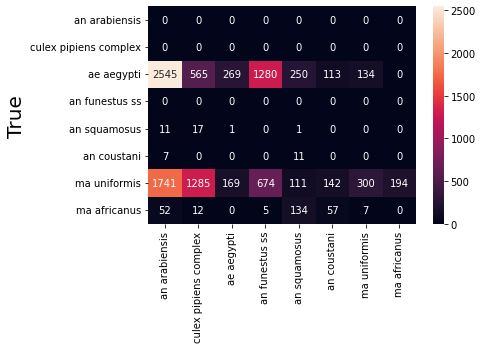

epoch = 1batch = 0 of 504duraation = 0.23501688639322918
epoch = 1batch = 200 of 504duraation = 5.912983961900076
epoch = 1batch = 400 of 504duraation = 11.585306231180827
Epoch: 1, Train Loss: 1.58586308, Train f1: 0.30361714, Val Loss: 0.01325696, Val f1: 0.17955998, overrun_counter -1
Saving model to: ../../models/model_e1_2022_11_12_19_59_02.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.04      0.08      4356
culex pipiens complex       0.35      0.41      0.38      1879
           ae aegypti       0.17      0.78      0.28       439
       an funestus ss       0.78      0.07      0.13      1959
         an squamosus       0.07      0.41      0.12       507
          an coustani       0.24      0.28      0.26       312
         ma uniformis       0.14      0.68      0.24       441
         ma africanus       0.04      0.01      0.01       194

        

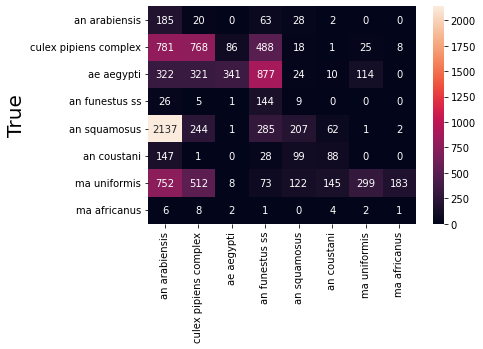

epoch = 2batch = 0 of 504duraation = 0.23325992822647096
epoch = 2batch = 200 of 504duraation = 5.748802642027537
epoch = 2batch = 400 of 504duraation = 11.418775538603464
Epoch: 2, Train Loss: 1.21181273, Train f1: 0.46632060, Val Loss: 0.01137013, Val f1: 0.31790664, overrun_counter -1
Saving model to: ../../models/model_e2_2022_11_12_20_21_29.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.70      0.14      0.23      4356
culex pipiens complex       0.34      0.52      0.41      1879
           ae aegypti       0.35      0.75      0.47       439
       an funestus ss       0.74      0.24      0.37      1959
         an squamosus       0.07      0.31      0.12       507
          an coustani       0.18      0.51      0.26       312
         ma uniformis       0.09      0.19      0.12       441
         ma africanus       0.17      0.71      0.28       194

        

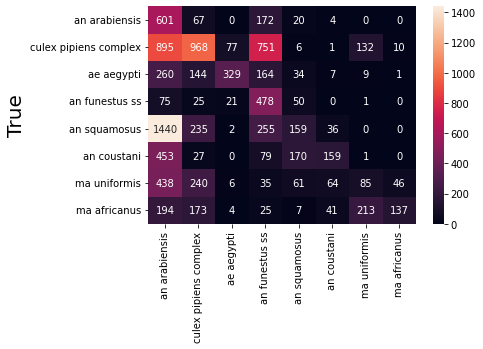

epoch = 3batch = 0 of 504duraation = 0.2356229027112325
epoch = 3batch = 200 of 504duraation = 5.7870370109876
epoch = 3batch = 400 of 504duraation = 11.477621642748515
Epoch: 3, Train Loss: 1.00611778, Train f1: 0.54531693, Val Loss: 0.00872356, Val f1: 0.52235894, overrun_counter -1
Saving model to: ../../models/model_e3_2022_11_12_20_43_58.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.80      0.47      0.59      4356
culex pipiens complex       0.37      0.50      0.43      1879
           ae aegypti       0.58      0.79      0.67       439
       an funestus ss       0.74      0.42      0.53      1959
         an squamosus       0.18      0.47      0.26       507
          an coustani       0.25      0.59      0.36       312
         ma uniformis       0.22      0.58      0.32       441
         ma africanus       0.38      0.18      0.24       194

           

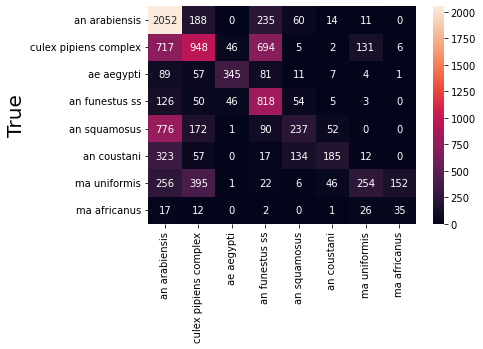

epoch = 4batch = 0 of 504duraation = 0.23764002323150635
epoch = 4batch = 200 of 504duraation = 5.827391807238261
epoch = 4batch = 400 of 504duraation = 11.414331301053364
..Overrun....no improvement
Epoch: 4, Train Loss: 0.86189508, Train f1: 0.59965553, Val Loss: 0.01063172, Val f1: 0.49055014, overrun_counter 0
epoch = 5batch = 0 of 504duraation = 0.22862764994303386
epoch = 5batch = 200 of 504duraation = 5.800294633706411
epoch = 5batch = 400 of 504duraation = 11.455330351988474
Epoch: 5, Train Loss: 0.79924952, Train f1: 0.63702392, Val Loss: 0.01036583, Val f1: 0.52621717, overrun_counter -1
Saving model to: ../../models/model_e5_2022_11_12_21_24_30.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.85      0.43      0.57      4356
culex pipiens complex       0.36      0.53      0.43      1879
           ae aegypti       0.66      0.68      0.67       439
       a

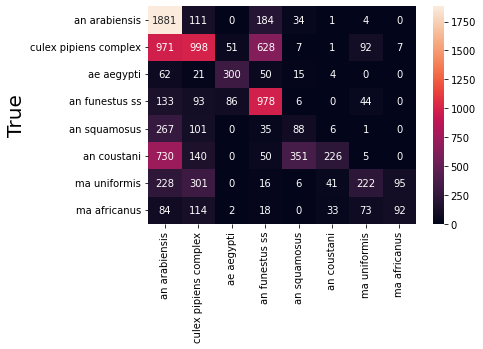

epoch = 6batch = 0 of 504duraation = 0.2311843713124593
epoch = 6batch = 200 of 504duraation = 5.697527186075846
epoch = 6batch = 400 of 504duraation = 11.375491786003114
Epoch: 6, Train Loss: 0.70015816, Train f1: 0.67823154, Val Loss: 0.00950998, Val f1: 0.56213222, overrun_counter -1
Saving model to: ../../models/model_e6_2022_11_12_21_47_04.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.85      0.46      0.60      4356
culex pipiens complex       0.39      0.50      0.44      1879
           ae aegypti       0.61      0.74      0.67       439
       an funestus ss       0.70      0.58      0.64      1959
         an squamosus       0.19      0.44      0.26       507
          an coustani       0.26      0.73      0.39       312
         ma uniformis       0.27      0.44      0.33       441
         ma africanus       0.26      0.52      0.35       194

         

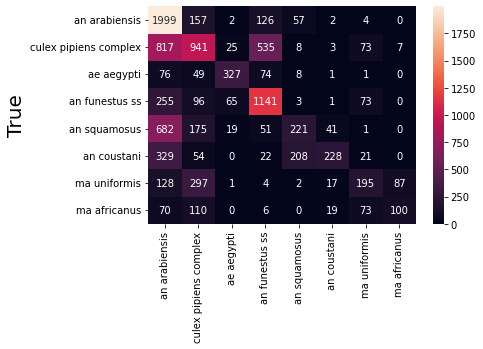

epoch = 7batch = 0 of 504duraation = 0.22704148292541504
epoch = 7batch = 200 of 504duraation = 5.865359381834666
epoch = 7batch = 400 of 504duraation = 11.459642783800762
Epoch: 7, Train Loss: 0.59438746, Train f1: 0.72567858, Val Loss: 0.00882938, Val f1: 0.58993936, overrun_counter -1
Saving model to: ../../models/model_e7_2022_11_12_22_09_28.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.85      0.53      0.66      4356
culex pipiens complex       0.42      0.59      0.49      1879
           ae aegypti       0.79      0.66      0.72       439
       an funestus ss       0.71      0.61      0.65      1959
         an squamosus       0.33      0.29      0.31       507
          an coustani       0.24      0.82      0.38       312
         ma uniformis       0.24      0.53      0.33       441
         ma africanus       0.52      0.39      0.45       194

        

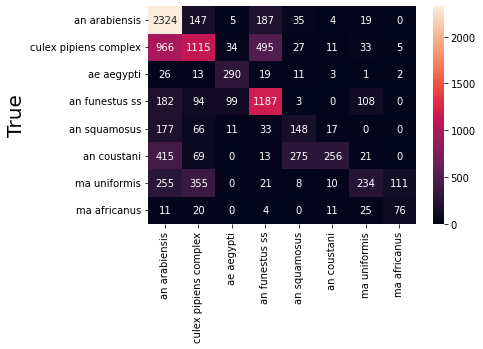

epoch = 8batch = 0 of 504duraation = 0.23295962810516357
epoch = 8batch = 200 of 504duraation = 5.707886791229248
epoch = 8batch = 400 of 504duraation = 11.367994717756908
..Overrun....no improvement
Epoch: 8, Train Loss: 0.52626380, Train f1: 0.75065738, Val Loss: 0.00927502, Val f1: 0.57590150, overrun_counter 0
epoch = 9batch = 0 of 504duraation = 0.2334635893503825
epoch = 9batch = 200 of 504duraation = 5.8577041864395145
epoch = 9batch = 400 of 504duraation = 11.407683726151784
..Overrun....no improvement
Epoch: 9, Train Loss: 0.47620704, Train f1: 0.76977290, Val Loss: 0.00885862, Val f1: 0.58303831, overrun_counter 1
epoch = 10batch = 0 of 504duraation = 0.23029428323109943
epoch = 10batch = 200 of 504duraation = 5.813623102506002
epoch = 10batch = 400 of 504duraation = 11.414704704284668
Epoch: 10, Train Loss: 0.44451458, Train f1: 0.78567894, Val Loss: 0.00841270, Val f1: 0.59497522, overrun_counter -1
Saving model to: ../../models/model_e10_2022_11_12_23_07_48.pth
Now printin

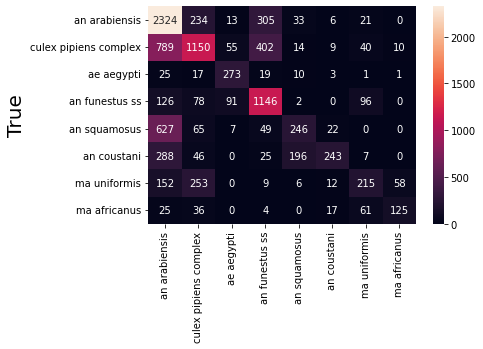

epoch = 11batch = 0 of 504duraation = 0.23504302501678467
epoch = 11batch = 200 of 504duraation = 5.7461168686548865
epoch = 11batch = 400 of 504duraation = 11.41686239639918
Epoch: 11, Train Loss: 0.40446128, Train f1: 0.79335903, Val Loss: 0.00916459, Val f1: 0.60362285, overrun_counter -1
Saving model to: ../../models/model_e11_2022_11_12_23_30_12.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.84      0.56      0.67      4356
culex pipiens complex       0.42      0.66      0.51      1879
           ae aegypti       0.76      0.67      0.71       439
       an funestus ss       0.78      0.59      0.67      1959
         an squamosus       0.40      0.42      0.41       507
          an coustani       0.35      0.59      0.44       312
         ma uniformis       0.23      0.40      0.29       441
         ma africanus       0.25      0.72      0.37       194

   

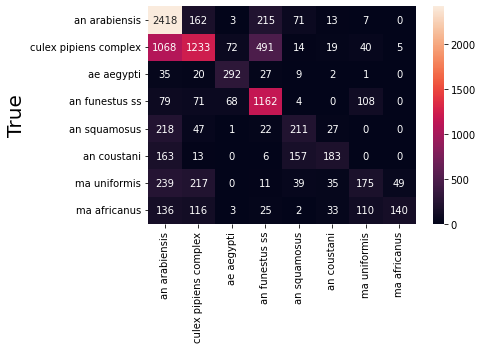

epoch = 12batch = 0 of 504duraation = 0.23565032879511516
epoch = 12batch = 200 of 504duraation = 5.7322488069534305
epoch = 12batch = 400 of 504duraation = 11.349482107162476
Epoch: 12, Train Loss: 0.35660666, Train f1: 0.81733758, Val Loss: 0.00808389, Val f1: 0.62606787, overrun_counter -1
Saving model to: ../../models/model_e12_2022_11_12_23_52_41.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.83      0.58      0.68      4356
culex pipiens complex       0.46      0.61      0.52      1879
           ae aegypti       0.89      0.47      0.62       439
       an funestus ss       0.68      0.65      0.67      1959
         an squamosus       0.31      0.64      0.42       507
          an coustani       0.34      0.57      0.43       312
         ma uniformis       0.34      0.54      0.41       441
         ma africanus       0.54      0.35      0.42       194

  

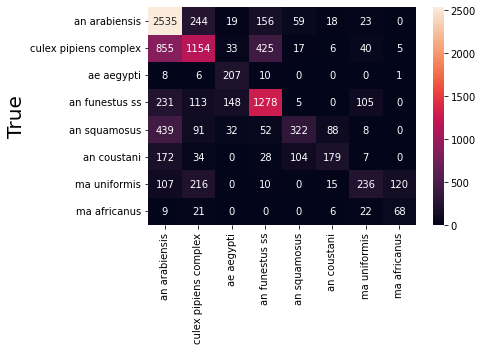

epoch = 13batch = 0 of 504duraation = 0.233523428440094
epoch = 13batch = 200 of 504duraation = 5.748584314187368
epoch = 13batch = 400 of 504duraation = 11.362750136852265
..Overrun....no improvement
Epoch: 13, Train Loss: 0.32960068, Train f1: 0.82964033, Val Loss: 0.00837785, Val f1: 0.61689481, overrun_counter 0
epoch = 14batch = 0 of 504duraation = 0.23376266956329345
epoch = 14batch = 200 of 504duraation = 5.956300822893779
epoch = 14batch = 400 of 504duraation = 11.592300244172414
Epoch: 14, Train Loss: 0.29409899, Train f1: 0.84589974, Val Loss: 0.00831055, Val f1: 0.64195740, overrun_counter -1
Saving model to: ../../models/model_e14_2022_11_13_00_33_19.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.78      0.67      0.72      4356
culex pipiens complex       0.48      0.64      0.55      1879
           ae aegypti       0.70      0.81      0.75       439
 

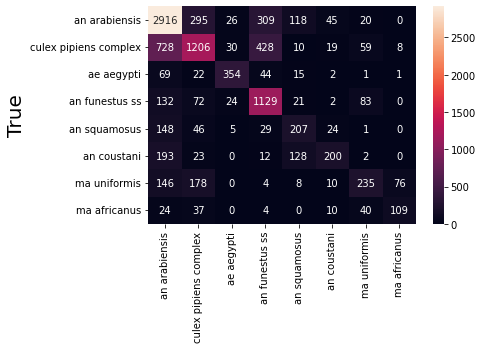

epoch = 15batch = 0 of 504duraation = 0.23636328776677448
epoch = 15batch = 200 of 504duraation = 5.921306935946147
epoch = 15batch = 400 of 504duraation = 11.5064635237058
..Overrun....no improvement
Epoch: 15, Train Loss: 0.25489478, Train f1: 0.85678194, Val Loss: 0.00855069, Val f1: 0.63914212, overrun_counter 0
epoch = 16batch = 0 of 504duraation = 0.2357990543047587
epoch = 16batch = 200 of 504duraation = 5.747998758157094
epoch = 16batch = 400 of 504duraation = 11.350101713339487
..Overrun....no improvement
Epoch: 16, Train Loss: 0.24789784, Train f1: 0.86954167, Val Loss: 0.00884052, Val f1: 0.63422058, overrun_counter 1
epoch = 17batch = 0 of 504duraation = 0.23629865646362305
epoch = 17batch = 200 of 504duraation = 5.892325707276663
epoch = 17batch = 400 of 504duraation = 11.561838734149934
..Overrun....no improvement
Epoch: 17, Train Loss: 0.23369342, Train f1: 0.87554230, Val Loss: 0.00831007, Val f1: 0.63511051, overrun_counter 2
epoch = 18batch = 0 of 504duraation = 0.233

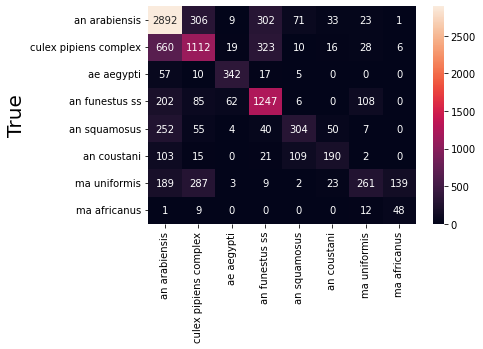

epoch = 21batch = 0 of 504duraation = 0.23050626516342163
epoch = 21batch = 200 of 504duraation = 5.727083178361257
epoch = 21batch = 400 of 504duraation = 11.42049110730489
Epoch: 21, Train Loss: 0.18423398, Train f1: 0.90617020, Val Loss: 0.00853814, Val f1: 0.65608743, overrun_counter -1
Saving model to: ../../models/model_e21_2022_11_13_02_48_57.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.81      0.66      0.73      4356
culex pipiens complex       0.50      0.67      0.57      1879
           ae aegypti       0.82      0.88      0.85       439
       an funestus ss       0.80      0.65      0.72      1959
         an squamosus       0.37      0.53      0.44       507
          an coustani       0.46      0.64      0.53       312
         ma uniformis       0.37      0.46      0.41       441
         ma africanus       0.54      0.61      0.57       194

    

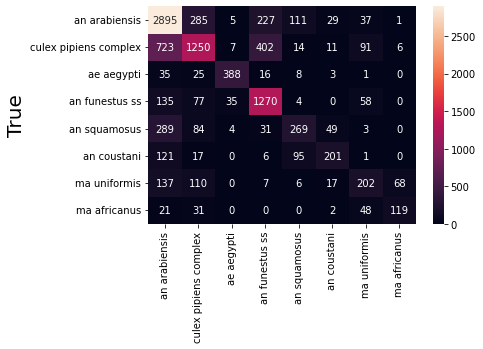

epoch = 22batch = 0 of 504duraation = 0.2303415854771932
epoch = 22batch = 200 of 504duraation = 5.908175178368887
epoch = 22batch = 400 of 504duraation = 11.530700250466664
..Overrun....no improvement
Epoch: 22, Train Loss: 0.18229072, Train f1: 0.91113598, Val Loss: 0.00865919, Val f1: 0.65411318, overrun_counter 0
epoch = 23batch = 0 of 504duraation = 0.23180538813273113
epoch = 23batch = 200 of 504duraation = 5.693011291821798
epoch = 23batch = 400 of 504duraation = 11.337398302555084
..Overrun....no improvement
Epoch: 23, Train Loss: 0.17480698, Train f1: 0.90931665, Val Loss: 0.00884611, Val f1: 0.65264966, overrun_counter 1
epoch = 24batch = 0 of 504duraation = 0.23304315010706583
epoch = 24batch = 200 of 504duraation = 5.735254840056101
epoch = 24batch = 400 of 504duraation = 11.338197155793507
Epoch: 24, Train Loss: 0.16899538, Train f1: 0.91253049, Val Loss: 0.00803805, Val f1: 0.65710660, overrun_counter -1
Saving model to: ../../models/model_e24_2022_11_13_03_47_09.pth
Now 

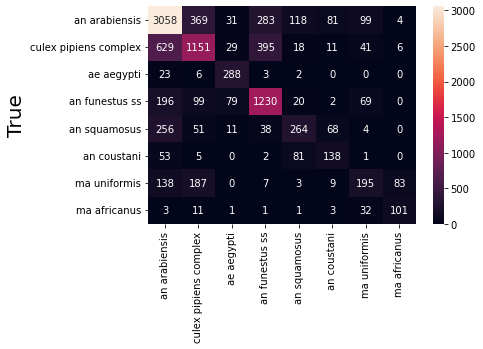

epoch = 25batch = 0 of 504duraation = 0.23341248432795206
epoch = 25batch = 200 of 504duraation = 5.763646459579467
epoch = 25batch = 400 of 504duraation = 11.383789066473643
Epoch: 25, Train Loss: 0.16744427, Train f1: 0.91464977, Val Loss: 0.00778226, Val f1: 0.67413912, overrun_counter -1
Saving model to: ../../models/model_e25_2022_11_13_04_09_37.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.79      0.70      0.74      4356
culex pipiens complex       0.55      0.69      0.61      1879
           ae aegypti       0.80      0.83      0.81       439
       an funestus ss       0.72      0.64      0.68      1959
         an squamosus       0.38      0.50      0.43       507
          an coustani       0.46      0.45      0.45       312
         ma uniformis       0.36      0.42      0.39       441
         ma africanus       0.57      0.58      0.58       194

   

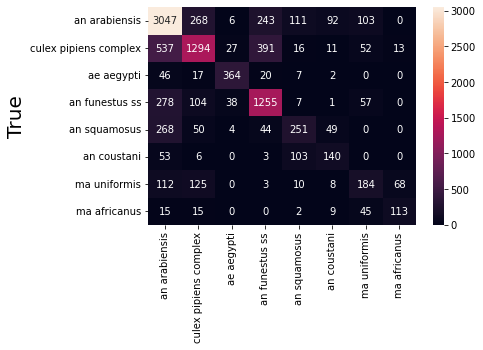

epoch = 26batch = 0 of 504duraation = 0.23518901268641154
epoch = 26batch = 200 of 504duraation = 5.870928593476614
epoch = 26batch = 400 of 504duraation = 11.455349743366241
..Overrun....no improvement
Epoch: 26, Train Loss: 0.16022678, Train f1: 0.92221469, Val Loss: 0.00849298, Val f1: 0.65468890, overrun_counter 0
epoch = 27batch = 0 of 504duraation = 0.22629226843516032
epoch = 27batch = 200 of 504duraation = 5.700301702817281
epoch = 27batch = 400 of 504duraation = 11.394273102283478
..Overrun....no improvement
Epoch: 27, Train Loss: 0.15754050, Train f1: 0.92228583, Val Loss: 0.00795121, Val f1: 0.65145839, overrun_counter 1
epoch = 28batch = 0 of 504duraation = 0.23017604351043702
epoch = 28batch = 200 of 504duraation = 5.7412015199661255
epoch = 28batch = 400 of 504duraation = 11.331506490707397
..Overrun....no improvement
Epoch: 28, Train Loss: 0.16718498, Train f1: 0.91401981, Val Loss: 0.01081784, Val f1: 0.65324122, overrun_counter 2
epoch = 29batch = 0 of 504duraation = 0

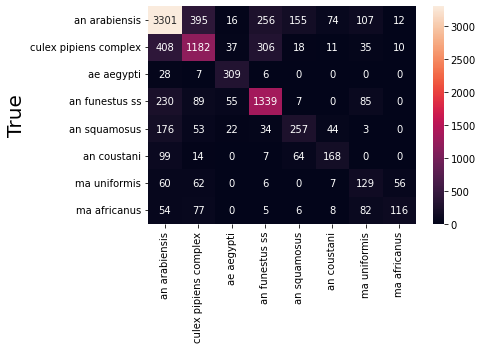

epoch = 38batch = 0 of 504duraation = 0.2303827961285909
epoch = 38batch = 200 of 504duraation = 5.74451797803243
epoch = 38batch = 400 of 504duraation = 11.349475892384847
..Overrun....no improvement
Epoch: 38, Train Loss: 0.11038539, Train f1: 0.94738137, Val Loss: 0.00940028, Val f1: 0.66825622, overrun_counter 0
epoch = 39batch = 0 of 504duraation = 0.23246887524922688
epoch = 39batch = 200 of 504duraation = 5.71228905916214
epoch = 39batch = 400 of 504duraation = 11.24828480084737
..Overrun....no improvement
Epoch: 39, Train Loss: 0.09711197, Train f1: 0.95181181, Val Loss: 0.00988779, Val f1: 0.65549092, overrun_counter 1
epoch = 40batch = 0 of 504duraation = 0.23569019635518393
epoch = 40batch = 200 of 504duraation = 5.816156752904257
epoch = 40batch = 400 of 504duraation = 11.36238626241684
Epoch: 40, Train Loss: 0.10080276, Train f1: 0.95084636, Val Loss: 0.00964025, Val f1: 0.68067750, overrun_counter -1
Saving model to: ../../models/model_e40_2022_11_13_08_47_44.pth
Now prin

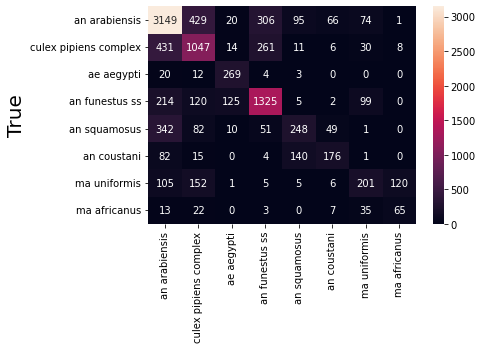

epoch = 41batch = 0 of 504duraation = 0.23196297883987427
epoch = 41batch = 200 of 504duraation = 5.75481626590093
epoch = 41batch = 400 of 504duraation = 11.328348537286123
..Overrun....no improvement
Epoch: 41, Train Loss: 0.11282831, Train f1: 0.95028740, Val Loss: 0.00804354, Val f1: 0.67488971, overrun_counter 0
epoch = 42batch = 0 of 504duraation = 0.22800854841868082
epoch = 42batch = 200 of 504duraation = 5.837823470433553
epoch = 42batch = 400 of 504duraation = 11.417818856239318
..Overrun....no improvement
Epoch: 42, Train Loss: 0.12207392, Train f1: 0.94605057, Val Loss: 0.00884496, Val f1: 0.65934430, overrun_counter 1
epoch = 43batch = 0 of 504duraation = 0.23880650997161865
epoch = 43batch = 200 of 504duraation = 5.664971343676249
epoch = 43batch = 400 of 504duraation = 11.33518590927124
Epoch: 43, Train Loss: 0.11066914, Train f1: 0.94877773, Val Loss: 0.00869891, Val f1: 0.68124022, overrun_counter -1
Saving model to: ../../models/model_e43_2022_11_13_09_45_49.pth
Now p

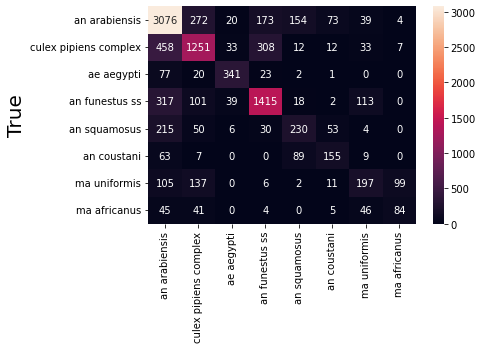

epoch = 44batch = 0 of 504duraation = 0.22742044925689697
epoch = 44batch = 200 of 504duraation = 5.674506767590841
epoch = 44batch = 400 of 504duraation = 11.267077696323394
..Overrun....no improvement
Epoch: 44, Train Loss: 0.13531479, Train f1: 0.93616968, Val Loss: 0.00908761, Val f1: 0.65320154, overrun_counter 0
epoch = 45batch = 0 of 504duraation = 0.22936132748921711
epoch = 45batch = 200 of 504duraation = 5.807717669010162
epoch = 45batch = 400 of 504duraation = 11.365272204081217
..Overrun....no improvement
Epoch: 45, Train Loss: 0.12028137, Train f1: 0.93597661, Val Loss: 0.00938444, Val f1: 0.66349687, overrun_counter 1
epoch = 46batch = 0 of 504duraation = 0.22658942540486654
epoch = 46batch = 200 of 504duraation = 5.885327772299449
epoch = 46batch = 400 of 504duraation = 11.42992996374766
..Overrun....no improvement
Epoch: 46, Train Loss: 0.12326725, Train f1: 0.93667803, Val Loss: 0.00910464, Val f1: 0.67154383, overrun_counter 2
epoch = 47batch = 0 of 504duraation = 0.2

In [ ]:
model =Model('swin_base_patch4_window7_224',224)
#model =Model('convnext_small',224)
#filepath = "../../models/model_e73_2022_10_08_07_44_27.pth"
#model_epcoh_99 = load_model(filepath,model)
model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
print("len of all_train_f1 = "+str(len(all_train_f1)))
print("len of all_val_f1 = "+str(len(all_val_f1)))
print("len of all_val_loss = "+str(len(all_val_loss)))
print("len of all_train_loss = "+str(len(all_train_loss)))


In [ ]:
all_val_f1_final =  [v for i, v in enumerate(all_val_f1) if i % 2 == 0]



In [ ]:
all_val_loss_final =  [v for i, v in enumerate(all_val_loss) if i % 2 == 0]

In [ ]:
all_train_f1_final =  [v for i, v in enumerate(all_train_f1) if i % 2 == 0]

In [ ]:
len(all_train_f1_final)

In [ ]:
len(all_train_f1)

In [ ]:
plot_df = pd.DataFrame({'train_loss':all_train_loss})

In [ ]:
plot_df['val_f1'] = all_val_f1_final

In [ ]:
plot_df['train_f1'] = all_train_f1_final

In [ ]:
plot_df['val_loss'] = all_val_loss_final

In [ ]:
#df.fillna(0)
plot_df.fillna(0)

In [ ]:
plot_df.iloc[129]

In [ ]:
#sns.lineplot(plot_df['train_f1','val_f1']);
plt.figure(figsize=(8,6)) 
sns.lineplot(plot_df[['train_f1','val_f1']])
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score - ConvNext Small")



In [ ]:
plt.figure(figsize=(8,6)) 
sns.lineplot(plot_df[['train_loss','val_loss']])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss - ConvNext Small")

In [ ]:
#df.to_csv('file1.csv')
plot_df.to_csv("plot_df_convNext_small.csv")

In [ ]:
len(all_val_f1)

In [ ]:
print(len(all_train_f1))

In [ ]:
val_dataset_new = MozTestDataset(df_val_offset,  config.data_dir, min_length)
val_loader_new = torch.utils.data.DataLoader(
        val_dataset, batch_size=2,
        num_workers=0, pin_memory=pin_memory  )



In [ ]:
df_error = df_val_offset
model = model_epcoh_10
model.to('cuda')
model.eval()
for idx,(x,y) in enumerate(val_dataset):
    print(idx)
    print(y)
    x = x.to('cuda').float()
    print("x shape = " +str(x.shape))
    #x_new = x.unsqueeze(dim = 1)
    print("x_new shape = " +str(x_new.shape))
    x_new = x.to('cuda')
    y_pred = model(x_new)['prediction']
    y_pred_cpu = y_pred.cpu().detach()
    preds = torch.argmax(y_pred_cpu, axis = 1)
    df_erroriloc[idx]['y_hat'] = preds
    del x_new
    

    

In [ ]:
x = torch.rand(1,15360)
x = x.unsqueeze(dim = 1)

In [ ]:
df_val_offset.head()
path_temp = "../data/audio/"
for i,row in df_val_offset.iterrows():
    print("i = " +str(i))
    print("id = " + str(int(row['id'])))
    file = str(int(row['id']))+".wav"
    print(file)
    path = path_temp + file
    waveform, inp_rate = torchaudio.load(path)
    if inp_rate != config.rate:
        import torchaudio.transforms as T
        resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
        waveform = resampler(waveform)
    if waveform.shape[1] < config.rate*min_length:
        #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
        f_out = pad_mean(waveform)
    else:
        f = waveform[0]
        f_out = f.unsqueeze(0)
    
    
               

In [ ]:
def get_tensor(df):
    
    path_name = "../data/audio/"
    file = df.loc[idx]['id'])}.wav")
    waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("")
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        
        if DEBUG:
            print("shape of x post augmentation = " + str(x.shape))
            
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("returning x of shape ..." + str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [ ]:
#Take the model checkpoint as a parameter as input
# read the val df
#get the tensor rep for the offset.
#pass it to the model get add get the prediction.


In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))